# Snapshot for Ouest France


Ce qui est affiché: cartes de la vitesse du courant à la surface de l'océan prédit par une simulation numérique haute de résolution.

snapshot_north_atlantic.jpg : une vue d'ensemble de l'Atlantique Ouest
snapshot_north_atlantic_zoom.jpg : un zoom (indiqué par le carré noir sur la vue d'ensemble). A titre d'indication la largeur de chaque fauchée SWOT fait 65 km approximativement.
    
Légende possible ... à adapter:
"Une image instantanée des courants à la surface de l'Océan illustre la richesse et diversité des phénomènes qui s'y déroulent.
Un des enjeux de l'Océanographie est de mieux observer ces phénomènes en particulier les tourbillons et fronts de taille inférieure à 100km.
Le satellite SWOT donc les fauchées sont représentées en gris sur ces figures est sur le point de nous fournir une perspective unique de ces phénomènes qui permettra notamment de comprendre ces phénomènes affectent le développement de la vie à la surface de l'océan, le transport et le mélange de propriétés clés pour l'équilibre physique de l'Océan mais aussi de polluants.
"

Un certain nombres d'éléments des figures peuvent être ajustés:

    - rapport d'aspect de la figure
    - gamme de couleur de la carte, voir: https://matplotlib.org/stable/tutorials/colors/colormaps.html  
       choix actuel = gnuplot2
    - des éléments de légende peuvent être ajoutés (fauchée SWOT, échelle spatialle de référence) mais je préfère vous laisser indiquer ce qui vous paraîtrait le plus approprié.
    - allure de continents




In [1]:
import os
#from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.plot as pl
import mitequinox.utils as ut
import mitequinox.parcels as pa

import warnings
warnings.filterwarnings('ignore')

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:

if False:
    
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
    #
    client = Client(cluster)
    client
    
else:
    
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
cluster

---
## load data

In [4]:
t = "2012-1-1 00"

In [5]:
ds = ut.load_data(["SSU", "SSV"]).sel(time=t)

grd = ut.load_grd(["XC", "YC", "CS", "SN"])
ds = xr.merge([ds, grd])

ds["SSU"] = ds.SSU.rename(i_g="i")
ds["SSV"] = ds.SSV.rename(j_g="j")

# rotated into zonal/meridional components
ds["u"] =  ds.SSU*ds.CS - ds.SSV*ds.SN
ds["v"] =  ds.SSU*ds.SN + ds.SSV*ds.CS

ds["speed"] = np.sqrt(ds.SSU**2+ds.SSV**2)

ds = ds.persist()

In [18]:
south_atlantic = {
    "faces": [1, 11, 0, 12],
    "extent": [-50, 20, -60, 5],
    "dticks": [10, 10],
    "projection": ccrs.LambertAzimuthalEqualArea(
        central_longitude=-15.0, central_latitude=-30
    ),
}


north_atlantic = {
    "faces": [2, 10],
    "extent": [-30, 10, 30, 60],
    "dticks": [10, 10],
    "projection": ccrs.LambertAzimuthalEqualArea(
        central_longitude=-10.0, central_latitude=30
    ),
}

land = {'args': ['physical', 'land', '50m'],
        'kwargs': dict(edgecolor='face',
                       facecolor='0.7', #cfeature.COLORS['land'],
                      )
       }

# load swot tracks
swot = ut.load_swot_tracks(phase="calval") #bbox=None
swot_kwargs = dict(
    facecolor="0.5",
    edgecolor="white",
    alpha=0.7,
)

#tr["swath"]

In [16]:
# zoom area
b = (2, 350, 550, 2300, 2500)
isel = dict(face=b[0], i=slice(b[1],b[2]), j=slice(b[3],b[4]))
delta = 50
isel_large = dict(face=b[0], i=slice(b[1]-delta,b[2]+delta), j=slice(b[3]-delta,b[4]+delta))
_lon, _lat = ds.XC.isel(**isel).compute().values, ds.YC.isel(**isel).compute().values

lonb = np.hstack([_lon[0,:], _lon[:,-1], _lon[-1,::-1], _lon[::-1,0]])
latb = np.hstack([_lat[0,:], _lat[:,-1], _lat[-1,::-1], _lat[::-1,0]])

zoom = [
    float(ds.XC.isel(**isel).min().compute()),
    float(ds.XC.isel(**isel).max().compute()),
    float(ds.YC.isel(**isel).min().compute()),
    float(ds.YC.isel(**isel).max().compute()),
]

region_zoom = {
    "faces": [2,],
    "extent": zoom,
    "dticks": [1, 1],
    "projection": ccrs.LambertAzimuthalEqualArea(
        central_longitude=(zoom[0]+zoom[1])/2, central_latitude=(zoom[2]+zoom[3])/2
    ),
}


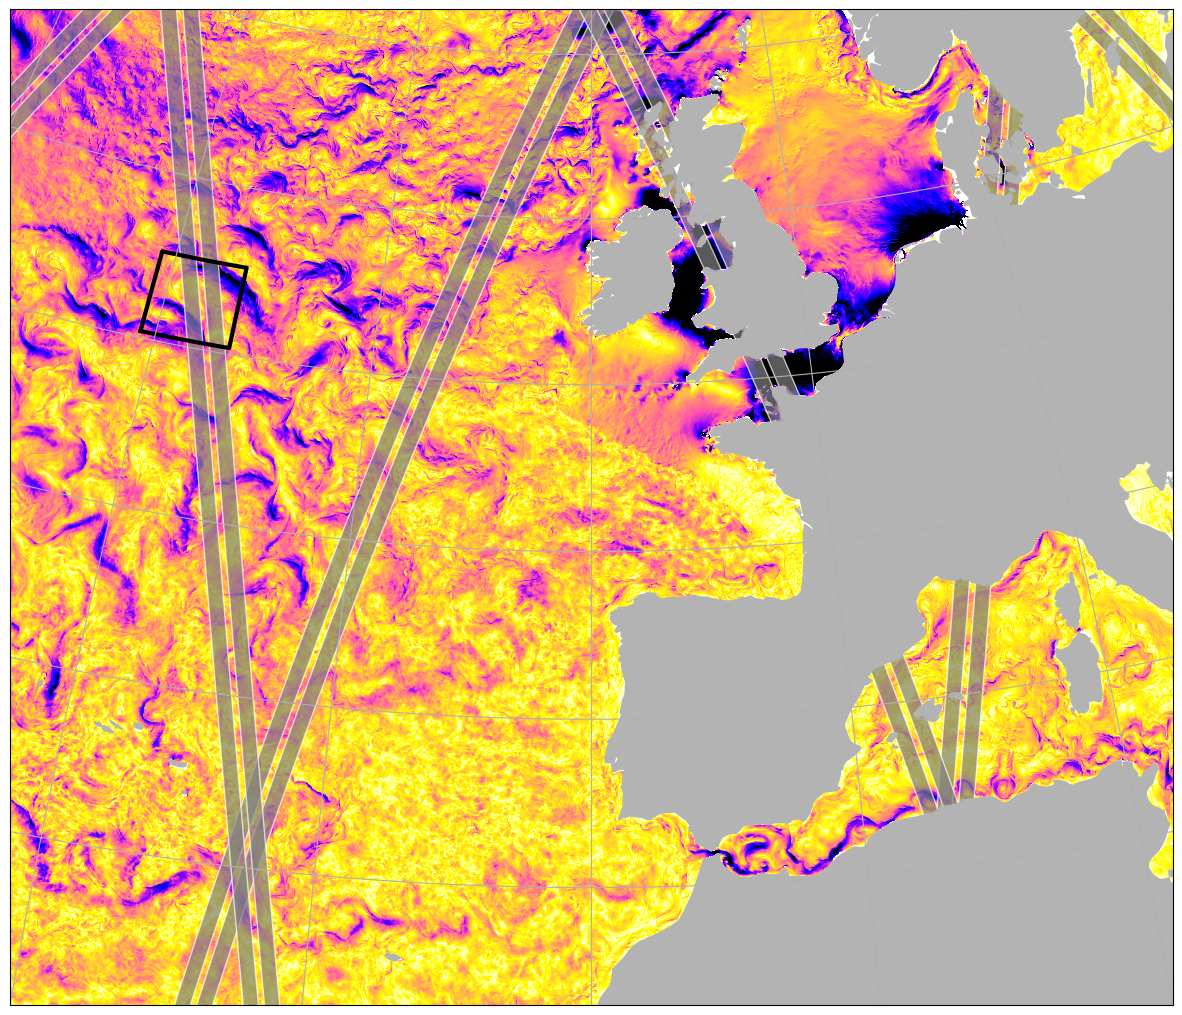

In [10]:
da = ds.speed
# subsample
#da = da.isel(i=slice(0,None,4), j=slice(0,None,4))

vmin, vmax = 0, 1
#cmap = "gist_stern_r"
cmap = "gnuplot2_r"

fac = pl.plot_pretty(da, 
                     region=north_atlantic,
                     vmin=vmin, vmax=vmax, 
                     cmap=cmap, 
                     #colorbar=True,
                     #swot_tracks=True, 
                     gridlines=False, 
                     land=land,
                    )
fig, ax = fac["fig"], fac["ax"]

ax.plot(lonb, latb, color="k", lw=3, transform=ccrs.PlateCarree()) #zorder=10

# add swot tracks
crs_proj4 = ax.projection.proj4_init
ax.add_geometries(
    swot["swath"].to_crs(crs_proj4)["geometry"],
    crs=ax.projection,
    **swot_kwargs,
)

ax.set_title("")

fig.savefig("snapshot_north_atlantic.jpg", dpi=300)

### zoom

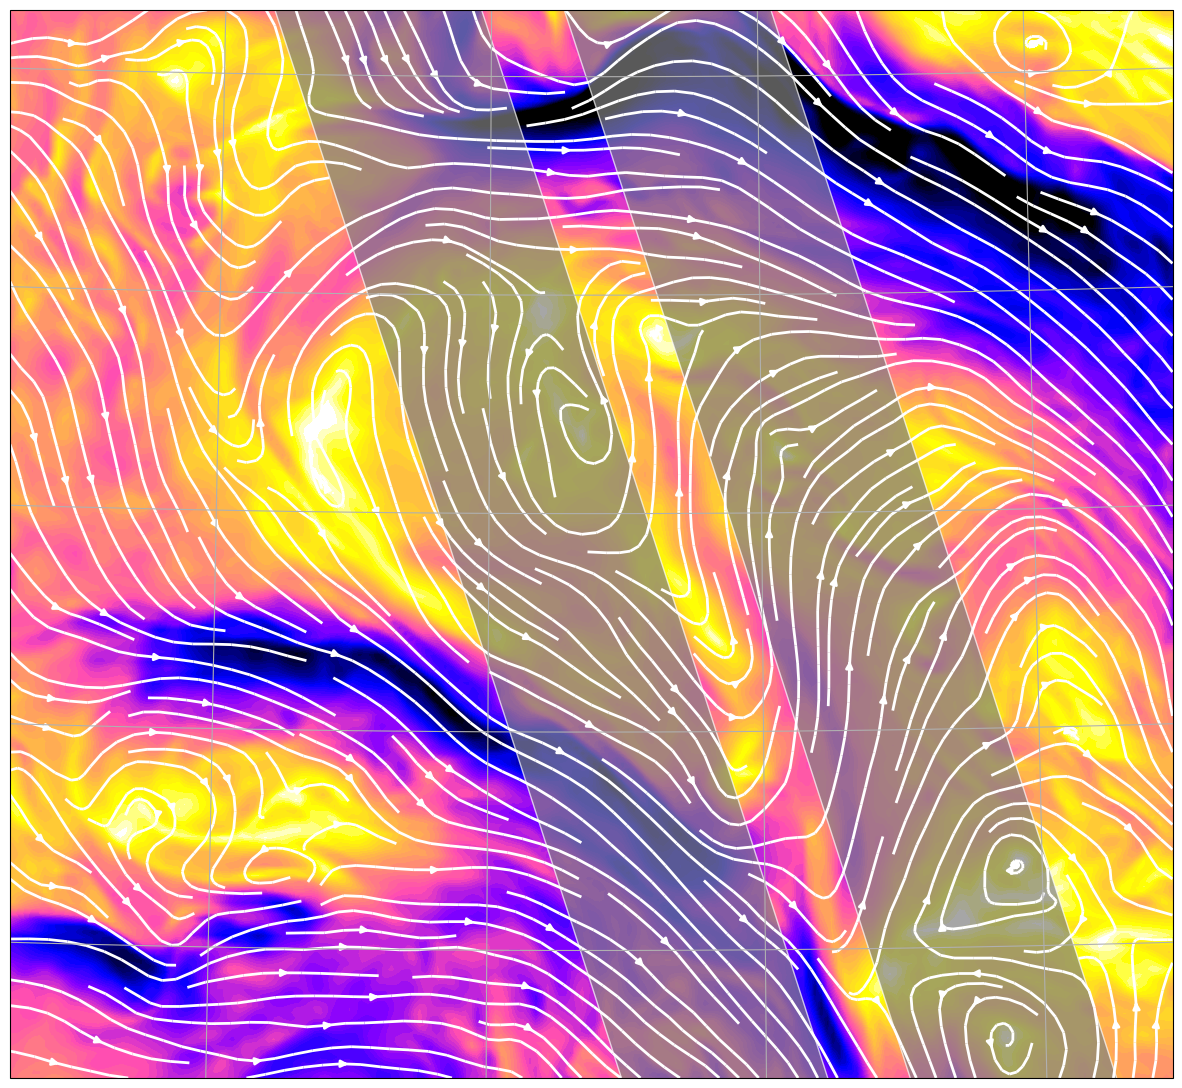

In [19]:
#_ds = ds.sel(face=[b[0]])

_ds = ds.isel(**isel_large)

# subsample / dev
#_ds = _ds.isel(i=slice(0,None,4), j=slice(0,None,4))

da = _ds.speed #.compute()

fac = pl.plot_pretty(da, 
                     region=region_zoom,
                     vmin=vmin, vmax=vmax, 
                     #cmap="gist_stern_r", 
                     cmap=cmap, 
                     #colorbar=True,
                     #cmap="gist_stern_r", 
                     #swot_tracks=True, 
                     gridlines=False, 
                     land=land,
                    )
fig, ax = fac["fig"], fac["ax"]

# add contours
da.squeeze().plot.contourf(ax=ax, x="XC", y="YC", 
                           levels=np.linspace(vmin,vmax, 50),
                           cmap=cmap,
                           transform=ccrs.PlateCarree(),
                           add_colorbar=False,
)

# streamlines
ax.streamplot(_ds.XC.squeeze(), _ds.YC.squeeze(), _ds.u.squeeze(), _ds.v.squeeze(), 
              color="w", density=2, linewidth=2,
              transform=ccrs.PlateCarree(),
)

#ax.plot(lonb, latb, color="k", lw=3, transform=ccrs.PlateCarree()) #zorder=10

# add swot tracks
crs_proj4 = ax.projection.proj4_init
ax.add_geometries(
    swot["swath"].to_crs(crs_proj4)["geometry"],
    crs=ax.projection,
    **swot_kwargs,
)

ax.set_title("")

fig.savefig("snapshot_north_atlantic_zoom.jpg", dpi=300)

In [29]:
pl.plot_pretty?

Signature:
pl.plot_pretty(
    v,
    title=None,
    vmin=None,
    vmax=None,
    fig=None,
    ax=None,
    region='global',
    projection=None,
    extent=None,
    ignore_face=[],
    cmap=None,
    pcolormesh_kwargs={},
    colorbar=False,
    colorbar_kwargs={},
    gridlines=True,
    land=True,
    coast_resolution='110m',
    offline=False,
    figsize=(15, 15),
    savefig=None,
    swot_tracks=False,
    **kwargs,
)
Docstring: <no docstring>
File:      ~/mit_equinox/mitequinox/plot.py
Type:      function

In [ ]:

cfeature = pl.cfeature
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '50m', **land["kwargs"])
#land_feature = cfeature.LAND

fig = plt.figure()
ax = fig.add_subplot(111, projection=fac["ax"].projection)
#fig, ax = plt.subplots(1,1, )
#ax.stock_img?
ax.add_feature(land_feature, zorder=2)

---
## close cluster

In [107]:
cluster.close()